In [1]:
# Data from https://grouplens.org/datasets/movielens/latest/
# Put the downloaded csv files in the "Downloads" folder

import os
os.chdir("Downloads")
print(os.getcwd())


c:\Users\vonks\Documents\GitHub\Movie_Recs\Downloads


In [2]:
import pandas as pd

ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

data = ratings.merge(movies, on="movieId", how="left")

In [ ]:
# Data overview
print(data.head(1))

print("\n# Users:", data['userId'].nunique())
print("# Movies:", data['movieId'].nunique())
print("# Ratings:", len(data))

duplicates = data.duplicated(subset=['userId', 'movieId'])
print("# Duplicates:", duplicates.sum())
print('# Missing: ')
print(data.isnull().sum())

   userId  movieId  rating   timestamp             title  \
0       1        1     4.0  1225734739  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  

# Users: 330975
# Movies: 83239
# Ratings: 33832162
# Duplicates: 0
# Missing: 
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


In [7]:
print(data['rating'].describe())
print(data['rating'].unique())

count    3.383216e+07
mean     3.542540e+00
std      1.063959e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64
[4.  4.5 5.  3.5 3.  2.  2.5 1.  1.5 0.5]


In [8]:
# Converting timestamp to datetime 
# seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970
# = unix epoch time default
data['time_rated'] = pd.to_datetime(data['timestamp'], unit='s')

print(data[['timestamp', 'time_rated']].head())

    timestamp          time_rated
0  1225734739 2008-11-03 17:52:19
1  1225865086 2008-11-05 06:04:46
2  1225733503 2008-11-03 17:31:43
3  1225735204 2008-11-03 18:00:04
4  1225735119 2008-11-03 17:58:39


In [9]:
print(data['time_rated'].describe())

count                         33832162
mean     2010-03-23 16:27:56.735719936
min                1995-01-09 11:46:44
25%                2003-03-03 18:56:32
50%                2010-01-29 04:42:24
75%      2017-06-08 10:56:19.249999872
max                2023-07-20 08:53:33
Name: time_rated, dtype: object


There seem to be no missing values or duplicates based on these results.
Ratings also vary from 0.5 to 5 which is expected. Next, distributions of the data will be visualized to check for any unexpected patterns etc.

If there were missing values I would have removed these, as it could introduce patterns based on missing values that could skew recommendations. In my opinion it is better to leave these rows out, recommendations can be made using similarities based on the other rows.

If there were duplicates, it would be necessary to investigate the nature of the duplication. If a duplication is of the same rating with the same movieID and userID, I would argue for removing them. 

If there are multiple ratings for the same movie with the same userID, I would argue for keeping only the latest timestep. In movie rating apps like "letterboxd", users can change their ratings so the last one should be used for user similarity.

## Data Exploration

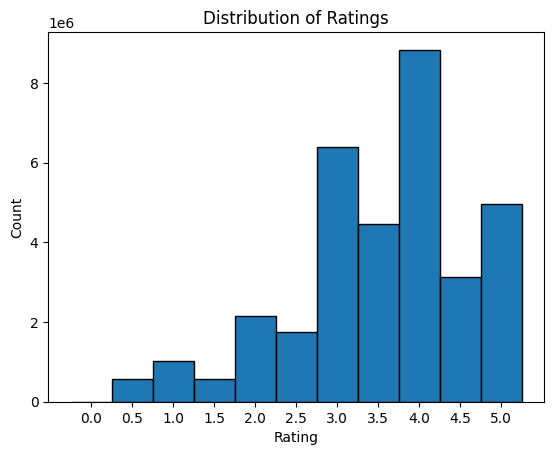

Mean rating: 3.54
Median rating: 4.00
Mode rating: 4.00


In [10]:
import numpy as np
import matplotlib.pyplot as plt

ratings = np.arange(0, 5.5, 0.5)

# Using np.histogram for time efficiency because data is large
counts, edges = np.histogram(data['rating'], bins=np.arange(-0.25, 5.25 + 0.5, 0.5))

plt.bar(ratings, counts, width=0.5, edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.xticks(ratings)
plt.show()

# Calculate mean, median, and mode of ratings
mean_rating = data['rating'].mean()
median_rating = data['rating'].median()
mode_rating = data['rating'].mode()[0]

print(f"Mean rating: {mean_rating:.2f}")
print(f"Median rating: {median_rating:.2f}")
print(f"Mode rating: {mode_rating:.2f}")


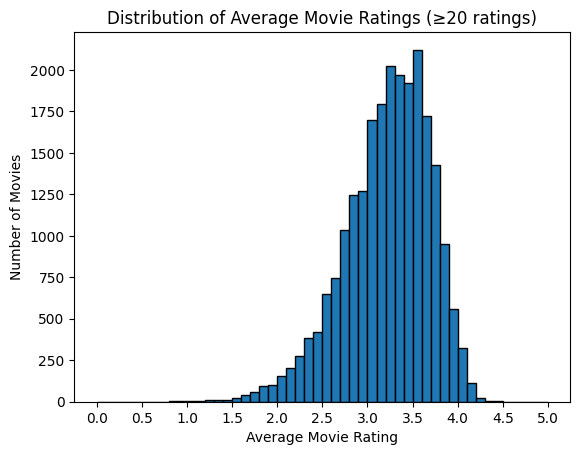

Mean of average ratings: 3.22
Median of average ratings: 3.27


In [11]:
# Distribution of average ratings per movie
import numpy as np
import matplotlib.pyplot as plt

# Filter movies with at least 20 ratings
movie_counts = data.groupby('movieId').size()
movies_with_enough_ratings = movie_counts[movie_counts >= 20].index
filtered_movies_data = data[data['movieId'].isin(movies_with_enough_ratings)]

# Compute average rating per movie after filtering
avg_ratings = filtered_movies_data.groupby('movieId')['rating'].mean().values

# Define bins of width 0.1: averages can be between 0 and 5
bin_width = 0.1
bins = np.arange(0, 5.0 + bin_width, bin_width)

# Compute histogram
counts, edges = np.histogram(avg_ratings, bins=bins)

# Compute bin centers (for centered bars)
bin_centers = edges[:-1] + bin_width / 2

# Plot
plt.bar(bin_centers, counts, width=bin_width, edgecolor='black', align='center')
plt.xlabel("Average Movie Rating")
plt.ylabel("Number of Movies")
plt.title("Distribution of Average Movie Ratings (≥20 ratings)")
plt.xticks(np.arange(0, 5.1, 0.5))
plt.show()

# Compute statistics for average ratings per movie
mean_avg = np.mean(avg_ratings)
median_avg = np.median(avg_ratings)

print(f"Mean of average ratings: {mean_avg:.2f}")
print(f"Median of average ratings: {median_avg:.2f}")


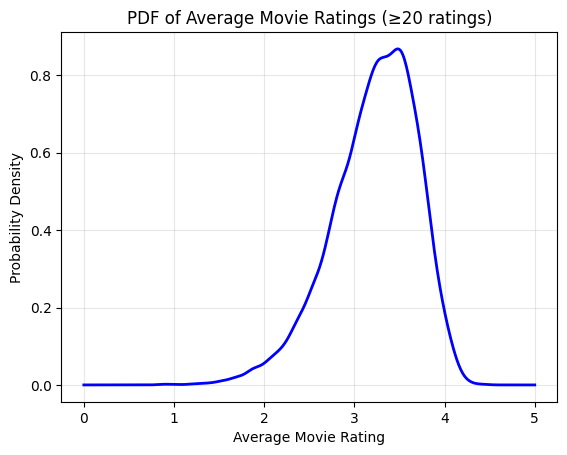

In [ ]:
# Probability Density Function (PDF) of average ratings per movie
from scipy.stats import gaussian_kde

# Kernel Density Estimate (KDE)
kde = gaussian_kde(avg_ratings)

# Grid of x values (0–5 range for ratings)
x_grid = np.linspace(0, 5, 500)

# Evaluate KDE on the grid
pdf_values = kde(x_grid)

# Plot as line graph
plt.plot(x_grid, pdf_values, color='blue', lw=2)
plt.xlabel("Average Movie Rating")
plt.ylabel("Probability Density")
plt.title("PDF of Average Movie Ratings (≥20 ratings)")
plt.grid(True, alpha=0.3)
plt.show()


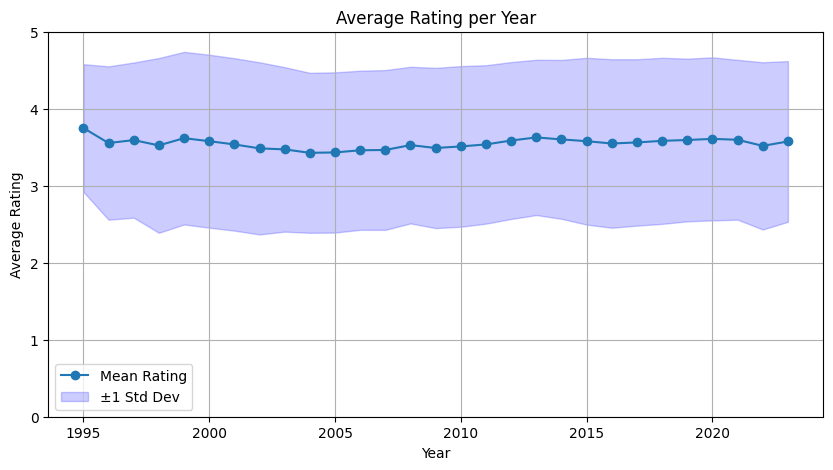

In [13]:
# Looking at time trends in ratings

# Extract year and ratings as arrays
years = data['time_rated'].dt.year.to_numpy(dtype=np.int16)
ratings = data['rating'].to_numpy()

unique_years, inv = np.unique(years, return_inverse=True)

# Compute sums, counts, sum of squares and mean per year
sums = np.bincount(inv, weights=ratings)
counts = np.bincount(inv)
sumsq = np.bincount(inv, weights=ratings**2)

avg_rating_per_year = sums / counts

# Variance and std per year
variance = (sumsq / counts) - (avg_rating_per_year**2)
std_per_year = np.sqrt(np.maximum(variance, 0)) 

# Plot mean with std shading
plt.figure(figsize=(10,5))
plt.plot(unique_years, avg_rating_per_year, marker='o', label="Mean Rating")
plt.fill_between(
    unique_years,
    avg_rating_per_year - std_per_year,
    avg_rating_per_year + std_per_year,
    color='blue', alpha=0.2, label="±1 Std Dev"
)

plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.title("Average Rating per Year")
plt.ylim((0, 5))
plt.grid(True)
plt.legend()
plt.show()


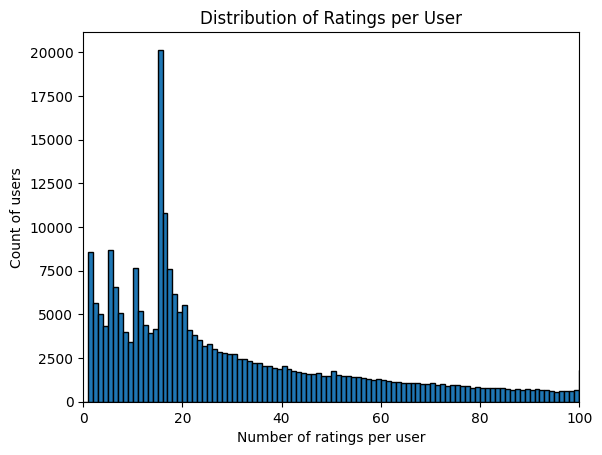

Mean:   102.22
Median: 31.0
Mode:   15
Min:    1
Max:    33332


In [ ]:
# Number of ratings per user distribution
from scipy import stats

# Count how many ratings each user has
ratings_per_user = data.groupby('userId').size().values

max_ratings = min(100, ratings_per_user.max())
bins = np.arange(0, max_ratings + 2, 1)

counts, edges = np.histogram(ratings_per_user, bins=bins)

# Barplot
plt.bar(edges[:-1], counts, width=1, edgecolor='black', align='edge')
plt.xlabel("Number of ratings per user")
plt.ylabel("Count of users")
plt.title("Distribution of Ratings per User")
plt.xlim(0, max_ratings)
plt.show()

# Compute statistics
mean_val = np.mean(ratings_per_user)
median_val = np.median(ratings_per_user)
mode_val = stats.mode(ratings_per_user, keepdims=True).mode[0]
min_val = np.min(ratings_per_user)
max_val = np.max(ratings_per_user)

print(f"Mean:   {mean_val:.2f}")
print(f"Median: {median_val}")
print(f"Mode:   {mode_val}")
print(f"Min:    {min_val}")
print(f"Max:    {max_val}")

As can be seen from the last statistics calculated, there seems to be a user that rated 33.332 movies. The mean (102) is also heavily skewed compared to the median (31). Indicating that there might be users that could be considered outliers.

Users seem to be more inclined to rate a movie with a round number of stars (3, 4, 5).

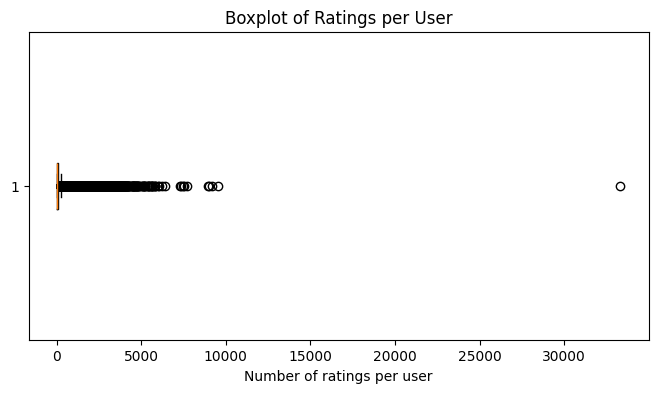

[33332  9554  9178  9016  8919  7719  7535  7488  7372  7266  6380  6199
  6074  5976  5806  5805  5784  5693  5653  5649  5633  5580  5525  5461
  5439]


In [ ]:
# Looking into outliers for number of ratings
plt.figure(figsize=(8, 4))
plt.boxplot(ratings_per_user, vert=False, showfliers=True)
plt.xlabel("Number of ratings per user")
plt.title("Boxplot of Ratings per User")
plt.show()

sorted_desc = np.sort(ratings_per_user)[::-1]
print(sorted_desc[:25])  # top 25 users by number of ratings


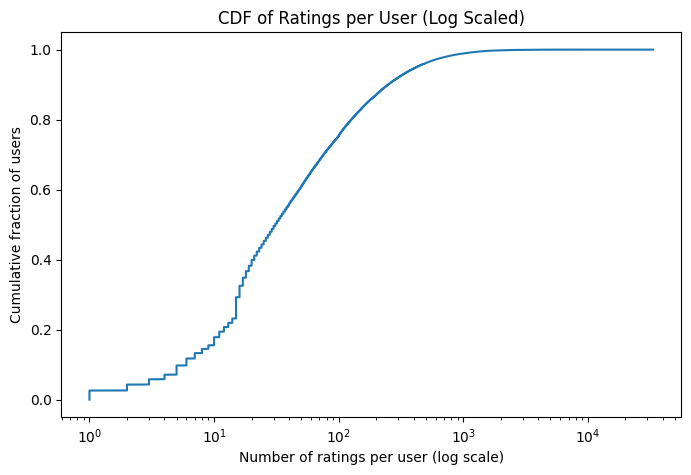

In [ ]:
# Cumulative Distribution Function (CDF) of number of ratings per user
sorted_vals = np.sort(ratings_per_user)
cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)

plt.figure(figsize=(8, 5))
plt.plot(sorted_vals, cdf)
plt.xscale("log")  # log scale for x-axis
plt.xlabel("Number of ratings per user (log scale)")
plt.ylabel("Cumulative fraction of users")
plt.title("CDF of Ratings per User (Log Scaled)")
plt.show()


Based on these figures, there definitely seems to be an outlier (or a very big movie fan) at 33K ratings. This one should definitely be removed.

We can also see the CDF already almost reaches 1 at 1000 ratings per user. We could therefore consider to only look at users with less than 1000 ratings.

In [14]:
# Removing users with more than 1,000 ratings as these are likely to be bots or outliers
# See Data_Exploration.ipynb for more details about cleaning and outlier detection

ratings_per_user = data.groupby('userId').size()
outliers = ratings_per_user[ratings_per_user > 1000]
filtered_data = data[~data['userId'].isin(outliers.index)]

# Table of removed users
removed_users_table = outliers.reset_index()
removed_users_table.columns = ['userId', 'num_ratings']

print(removed_users_table)


      userId  num_ratings
0        149         1507
1        198         1255
2        305         1406
3        461         1692
4        487         2164
...      ...          ...
3646  330517         2304
3647  330535         2791
3648  330687         1535
3649  330842         1288
3650  330914         1404

[3651 rows x 2 columns]


In [15]:
# Introducing genres
import pandas as pd

movies['genre_list'] = movies['genres'].str.split('|')

all_genres = sorted({g for genres in movies['genre_list'] for g in genres})

# One-hot encode genres
for g in all_genres:
    movies[g] = movies['genre_list'].apply(lambda x: int(g in x))

filtered_data_genres = filtered_data.merge(movies[['movieId'] + all_genres], on='movieId', how='left')


In [16]:
# Genre summary (Movies have multiple genres)

unique_movies = filtered_data_genres.drop_duplicates(subset='movieId')

genre_counts = unique_movies[all_genres].sum().sort_values(ascending=False)

genre_summary = genre_counts.reset_index()
genre_summary.columns = ['genre', 'num_movies']

print(genre_summary)


                 genre  num_movies
0                Drama       24408
1               Comedy       17023
2             Thriller        8552
3              Romance        7741
4               Action        7118
5               Horror        6122
6          Documentary        5886
7                Crime        4870
8            Adventure        4109
9               Sci-Fi        3732
10           Animation        3431
11            Children        3412
12  (no genres listed)        3322
13             Fantasy        3024
14             Mystery        2845
15                 War        1655
16             Musical         932
17             Western         914
18           Film-Noir         289
19                IMAX         195


In [ ]:
import pandas as pd

# Prepare dictionary to store stats per genre
genre_stats = {}

for g in all_genres:
    # Mask all rows corresponding to this genre = where genre is true
    mask = filtered_data_genres[g] == 1
    genre_ratings = filtered_data_genres.loc[mask, 'rating']
    
    # Unique movies for this genre
    genre_movies = filtered_data_genres.loc[mask, 'movieId'].unique()
    
    # Compute statistics
    avg = genre_ratings.mean()
    med = genre_ratings.median()
    std = genre_ratings.std()
    n_ratings = len(genre_ratings)
    n_movies = len(genre_movies)
    
    genre_stats[g] = {
        'mean_rating': avg,
        'median_rating': med,
        'std_rating': std,
        'num_ratings': n_ratings,
        'num_movies': n_movies
    }

# Convert to DataFrame
genre_stats_df = pd.DataFrame(genre_stats).T  # genres as rows
genre_stats_df = genre_stats_df.sort_values('mean_rating', ascending=False)

print(genre_stats_df)


                    mean_rating  median_rating  std_rating  num_ratings  \
Film-Noir              3.962923            4.0    0.913845     257656.0   
War                    3.853388            4.0    0.982726    1448399.0   
Documentary            3.786496            4.0    1.036530     293910.0   
Crime                  3.762747            4.0    0.999585    4793199.0   
Drama                  3.749572            4.0    0.994150   12180424.0   
Mystery                3.739315            4.0    0.997614    2289389.0   
Animation              3.669209            4.0    1.034034    1988508.0   
IMAX                   3.659594            4.0    1.054969    1373204.0   
Western                3.643076            4.0    1.021007     519170.0   
Romance                3.604522            4.0    1.046858    4948379.0   
Thriller               3.599755            4.0    1.033387    7630787.0   
(no genres listed)     3.598420            4.0    1.170094      30578.0   
Musical                3.

In [18]:
# Movies with genre string exactly "(no genres listed)"
no_genre_movies = movies[movies['genres'] == "(no genres listed)"]

print(f"Number of movies with no genres: {len(no_genre_movies)}")
print(no_genre_movies[['movieId', 'title', 'genres']].head(1))

Number of movies with no genres: 7060
       movieId                                  title              genres
15884    83773  Away with Words (San tiao ren) (1999)  (no genres listed)


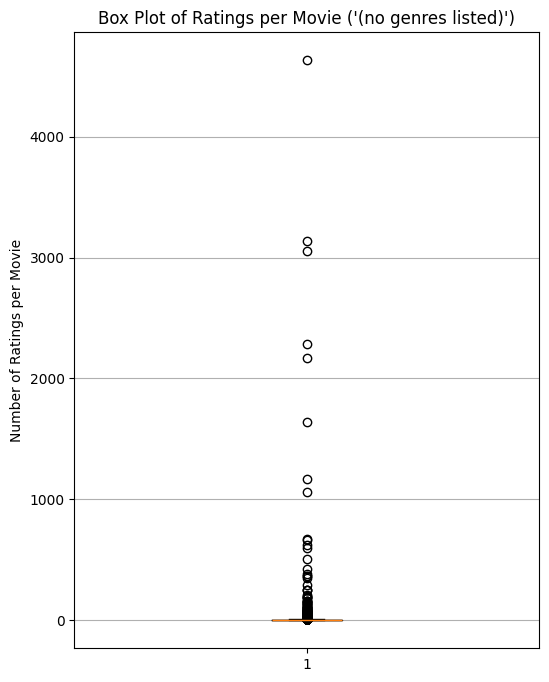

56059


In [20]:
# Get only movies with "(no genres listed)"
no_genre_movies_ids = no_genre_movies['movieId'].unique()

# Count number of ratings per movie
ratings_per_movie = data[data['movieId'].isin(no_genre_movies_ids)].groupby('movieId').size()

# Box plot
plt.figure(figsize=(6,8))
plt.boxplot(ratings_per_movie, vert=True)
plt.ylabel("Number of Ratings per Movie")
plt.title("Box Plot of Ratings per Movie ('(no genres listed)')")
plt.grid(True, axis='y')
plt.show()

print(ratings_per_movie.sum())


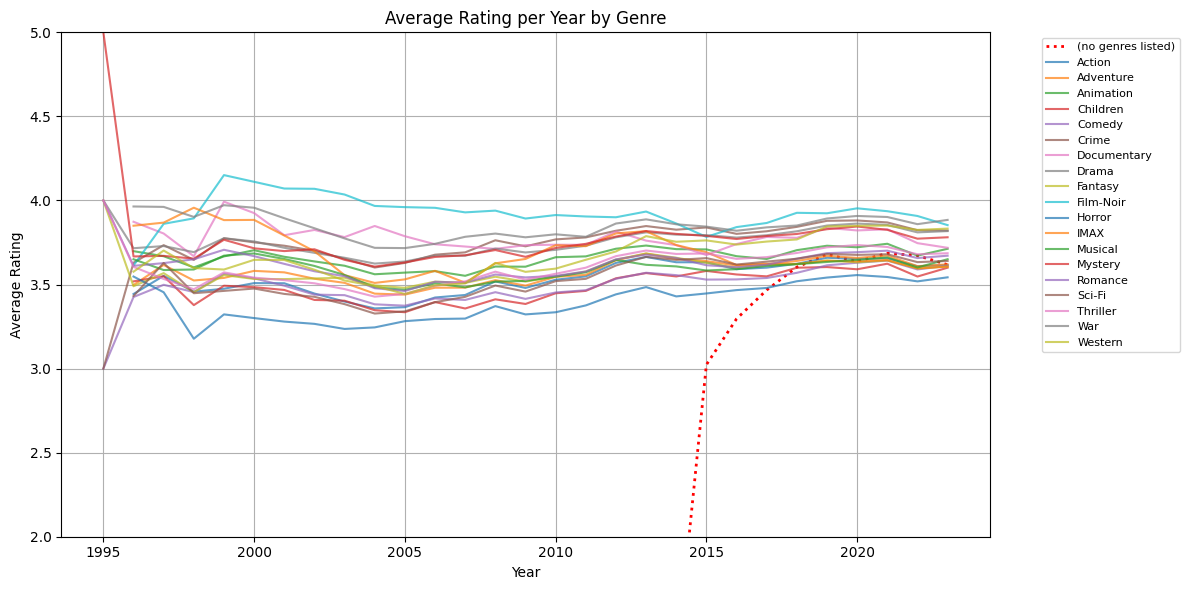

In [ ]:
# Time trends per genre

# Add year column from timestamp
filtered_data_genres['year'] = filtered_data_genres['time_rated'].dt.year

# Group by year and genre
genre_trends = {}
for g in all_genres:
    # Mask ratings belonging to this genre
    genre_mask = filtered_data_genres[g] == 1
    genre_year_avg = (
        filtered_data_genres.loc[genre_mask]
        .groupby('year')['rating']
        .mean()
    )
    genre_trends[g] = genre_year_avg

# Combine into one DataFrame (years as index, genres as columns)
genre_trends_df = pd.DataFrame(genre_trends)

plt.figure(figsize=(12, 6))

for g in all_genres:
    if genre_trends_df[g].notna().sum() > 0:  # skip genres with no data
        if g == "(no genres listed)":
            plt.plot(genre_trends_df.index, genre_trends_df[g], label=g, linestyle=':', color='red', linewidth=2)
        else:
            plt.plot(genre_trends_df.index, genre_trends_df[g], label=g, linestyle='-', alpha=0.7)

plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.ylim((2, 5))
plt.title("Average Rating per Year by Genre")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()



Based on this we can conclude that there are no anomaly genres tags since the least frequent one is IMAX. We can see that there are no weird labels apart from "no genres listed" which was used in the dataset as a placeholder for empty cells. Based on the ratings over year, the "no genres listed" could be removed as it behaves differently. It only has 56000 ratings out of the 33 million so it likely will not make much of a difference. 

They are likely to be more obscure movies which could explain a lower rating.